In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

**Generate Data**

In [2]:
x, y = make_classification(n_samples=1000, n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1, random_state=42)

print(f"Dataset shape: {x.shape}")
print(f"Classes: {np.unique(y)}")
print(f"Class distribution: {np.bincount(y)}")

Dataset shape: (1000, 2)
Classes: [0 1]
Class distribution: [501 499]


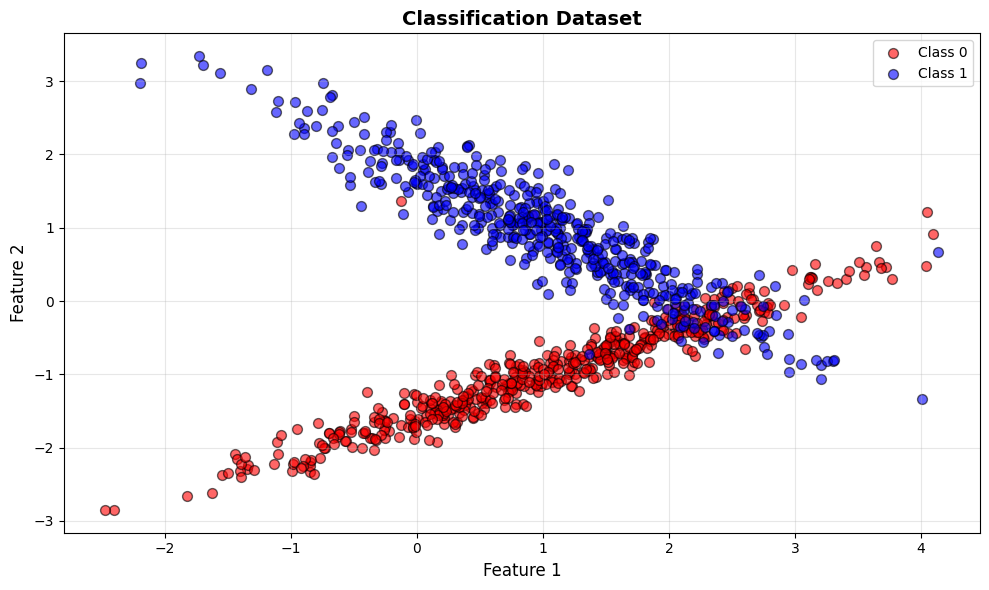

In [3]:
plt.figure(figsize=(10, 6))
plt.scatter(x[y == 0, 0], x[y == 0, 1], c='red', alpha=0.6, s=50, label='Class 0', edgecolors='black')
plt.scatter(x[y == 1, 0], x[y == 1, 1], c='blue', alpha=0.6, s=50, label='Class 1', edgecolors='black')
plt.xlabel('Feature 1', fontsize=12)
plt.ylabel('Feature 2', fontsize=12)
plt.title('Classification Dataset', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Preprocess Data**

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42, stratify=y)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [5]:
# Reshape y for neural network
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print(f"Training set: {x_train_scaled.shape}")
print(f"Test set: {x_test_scaled.shape}")
print(f"Target training set: {y_train.shape}")

Training set: (800, 2)
Test set: (200, 2)
Target training set: (800, 1)


In [8]:
x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(
    x_train_scaled, y_train, test_size=.20, random_state=42, stratify=y_train
)

print(f"Final Training set: {x_train_split.shape}")
print(f"Validation set: {x_val_split.shape}")

Final Training set: (640, 2)
Validation set: (160, 2)


**Define Neural Network Class**

In [18]:
class NeuralNetwork:
    def __init__(self, layers, learning_rate=0.01, activation='sigmoid'):
         self.layers = layers
         self.learning_rate = learning_rate
         self.activation = activation
         self.weights = []
         self.biases = []
         self.history = {'loss' : [], 'accuracy' : []}
         
         # Xavier initialization for sigmoid, He for ReLU
         for i in range(len(layers) - 1):
            if activation == 'relu':
                 std = np.sqrt(2.0 / layers[i])
            else:
                std = np.sqrt(1.0 / layers[i])
            
            w = np.random.randn(layers[i], layers[i+1]) * std
            b = np.zeros((1, layers[i+1]))
            self.weights.append(w)
            self.biases.append(b)
        
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -250, 250)))
    
    def sigmoid_derivative(self, x):
        s = self.sigmoid(x)
        return s * (1 - s)
    
    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return (x > 0).astype(float)
    
    def activate(self, x):
        if self.activation == 'relu':
            return self.relu(x)
        return self.sigmoid(x)
    
    def activate_derivative(self, x):
        if self.activation == 'relu':
            return self.relu_derivative(x)
        return self.sigmoid_derivative(x)
    
    
    def forward(self, x):
        activations = [x]
        for i in range(len(self.weights)):
            z = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            a = self.activate(z)
            activations.append(a)
        return activations
    
    def predict(self, x):
        activations = self.forward(x)
        predictions = activations[-1]
        return (predictions > 0.5).astype(int)
    
    def predict_proba(self, x):
        activations = self.forward(x)
        return activations[-1]
    
    
    def backward(self, activations, y):
        m = y.shape[0]
        gradients_w = []
        gradients_b = []
        
        # Output layer error
        error = activations[-1] - y
        delta = error * self.activate_derivative(activations[-1])
        
        for i in range(len(self.weights) - 1, -1, -1):
            grad_w = np.dot(activations[i].T, delta) / m
            grad_b = np.sum(delta, axis=0, keepdims=True) / m
            
            gradients_w.insert(0, grad_w)
            gradients_b.insert(0, grad_b)
            
            if i > 0:
                delta = np.dot(delta, self.weights[i].T)
                delta = delta * self.activate_derivative(activations[i])
        
        return gradients_w, gradients_b
    
    
    def compute_loss(self, y_true, y_pred):
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        return loss
    
    def compute_accuracy(self, y_true, y_pred):
        predictions = (y_pred > 0.5).astype(int)
        accuracy = np.mean(predictions == y_true)
        return accuracy

    def fit(self, x, y, epochs=1000, batch_size=32, verbose=True, x_val=None, y_val=None):
        n_sample = len(x)
        for epoch in range(epochs):
            indices = np.random.permutation(n_sample)
            epoch_loss = 0
            
            # Mini-batch training
            for i in range(0, n_sample, batch_size):
                batch_indices = indices[i:i+batch_size]
                batch_x = x[batch_indices]
                batch_y = y[batch_indices]
                
                # Forward pass
                activations = self.forward(batch_x)
                
                # Compute loss
                batch_loss = self.compute_loss(batch_y, activations[-1])
                epoch_loss += batch_loss
                
                # Backward pass
                grad_w, grad_b = self.backward(activations, batch_y)
                
                # Update weights
                for j in range(len(self.weights)):
                    self.weights[j] -= self.learning_rate * grad_w[j]
                    self.biases[j] -= self.learning_rate * grad_b[j]
                
            # Average loss for epoch
            avg_loss = epoch_loss / (n_sample // batch_size)
                
            # Compute accuracy
            train_pred = self.predict_proba(x)
            train_accuracy = self.compute_accuracy(y, train_pred)
                
            # Store history
            self.history['loss'].append(avg_loss)
            self.history['accuracy'].append(train_accuracy)
                
            # Validation
            if x_val is not None and y_val is not None:
                val_pred = self.predict_proba(x_val)
                val_loss =self.compute_loss(y_val, val_pred)
                val_acc = self.compute_accuracy(y_val, val_pred)
                    
                if verbose and epoch % 100 == 0:
                    print(f"Epoch {epoch}: Loss = {avg_loss:.4f}, Train Acc = {train_accuracy:.4f}, "
                          f"Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}")
            else:
                if verbose and epoch % 100 == 0:
                        print(f"Epoch {epoch}: Loss = {avg_loss:.4f}, Accuracy = {train_accuracy:.4f}")

In [19]:
nn = NeuralNetwork(layers=[2, 8, 4, 1], learning_rate=0.01, activation='sigmoid')

nn.fit(x_train_split, y_train_split, epochs=1000, batch_size=32, x_val=x_val_split, y_val=y_val_split)

Epoch 0: Loss = 0.7439, Train Acc = 0.5016, Val Loss = 0.7430, Val Acc = 0.5000
Epoch 100: Loss = 0.6911, Train Acc = 0.5016, Val Loss = 0.6913, Val Acc = 0.5000
Epoch 200: Loss = 0.6856, Train Acc = 0.8328, Val Loss = 0.6859, Val Acc = 0.8438
Epoch 300: Loss = 0.6786, Train Acc = 0.8812, Val Loss = 0.6793, Val Acc = 0.8562
Epoch 400: Loss = 0.6683, Train Acc = 0.8969, Val Loss = 0.6696, Val Acc = 0.8688
Epoch 500: Loss = 0.6527, Train Acc = 0.8984, Val Loss = 0.6548, Val Acc = 0.8688
Epoch 600: Loss = 0.6291, Train Acc = 0.8969, Val Loss = 0.6323, Val Acc = 0.8750
Epoch 700: Loss = 0.5946, Train Acc = 0.9000, Val Loss = 0.5995, Val Acc = 0.8688
Epoch 800: Loss = 0.5478, Train Acc = 0.8969, Val Loss = 0.5549, Val Acc = 0.8688
Epoch 900: Loss = 0.4912, Train Acc = 0.8938, Val Loss = 0.5012, Val Acc = 0.8625


**Evaluate and Visualize**

In [20]:
test_pred = nn.predict(x_test_scaled)
test_proba = nn.predict_proba(x_test_scaled)
test_acc = nn.compute_accuracy(y_test, test_proba)

print(f"\nTest Accuracy: {test_acc:.4f}")


Test Accuracy: 0.8750


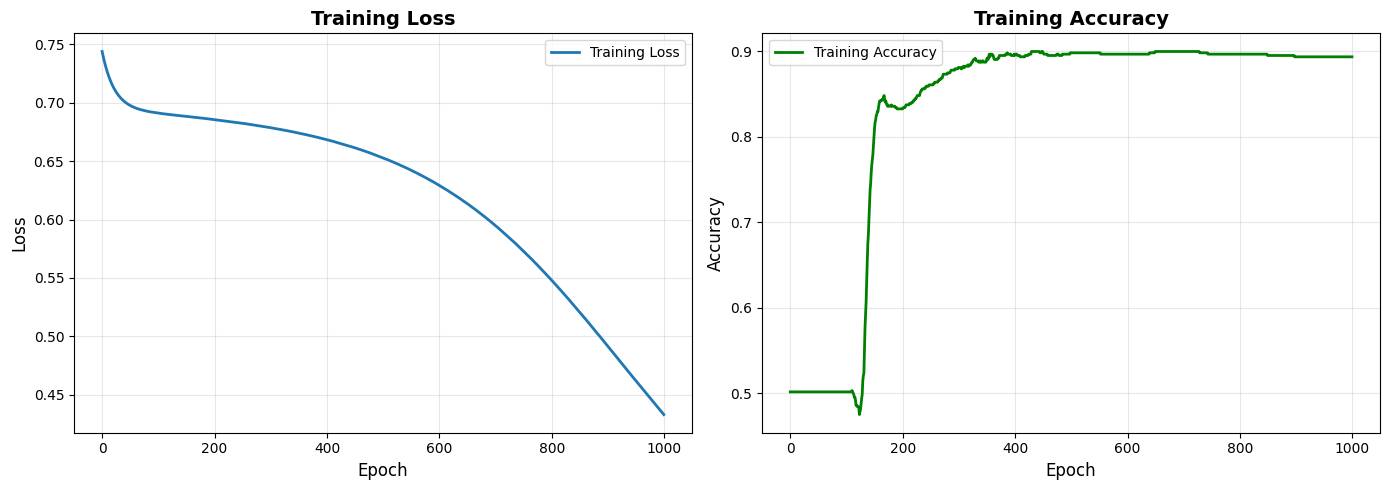

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(nn.history['loss'], linewidth=2, label='Training Loss')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(nn.history['accuracy'], linewidth=2, label='Training Accuracy', color='green')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Training Accuracy', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

- Visualize Decision Boundary

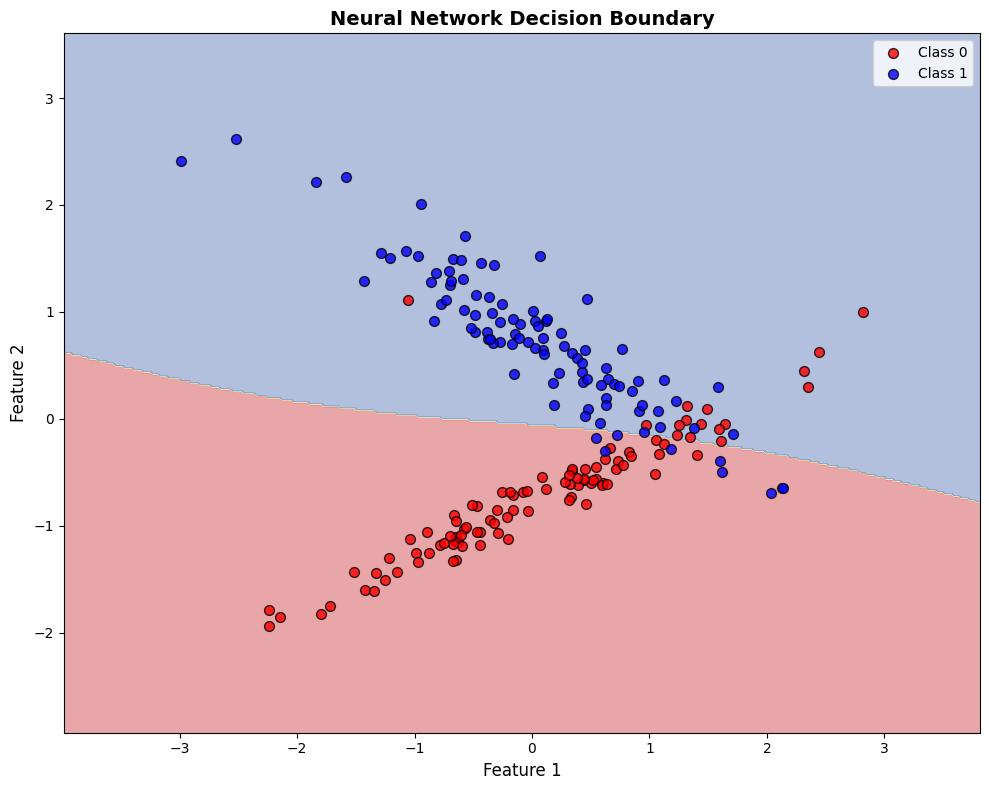

In [23]:
def plot_decision_boundary(model, x, y):
    h = 0.02    # step size
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    mesh_point = np.c_[xx.ravel(), yy.ravel()]
    z = model.predict(mesh_point)
    z = z.reshape(xx.shape)
    
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, z, alpha=0.4, cmap='RdYlBu')
    plt.scatter(x[y.flatten() == 0, 0], x[y.flatten() == 0, 1], 
               c='red', s=50, alpha=0.8, label='Class 0', edgecolors='black')
    plt.scatter(x[y.flatten() == 1, 0], x[y.flatten() == 1, 1], 
               c='blue', s=50, alpha=0.8, label='Class 1', edgecolors='black')
    plt.xlabel('Feature 1', fontsize=12)
    plt.ylabel('Feature 2', fontsize=12)
    plt.title("Neural Network Decision Boundary", fontsize=14, fontweight='bold')
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_decision_boundary(nn, x_test_scaled, y_test)

**Improve the Model**

- Try Different Architectures

In [24]:
architectures = [
    ([2, 4, 1], "Small Network"),
    ([2, 8, 4, 1], "Medium Network"),
    ([2, 16, 8, 4, 1], "Deep Network")
]

results = []

for layers, name in architectures:
    print(f"\nTraining {name}...")
    nn = NeuralNetwork(layers=layers, learning_rate=0.01, activation='sigmoid')
    nn.fit(x_train_split, y_train_split, epochs=500, batch_size=32, verbose=False)
    
    test_pred = nn.predict_proba(x_test_scaled)
    test_acc = nn.compute_accuracy(y_test, test_pred)
    
    results.append((name, test_acc))
    print(f"{name} Test Accuracy: {test_acc:.4f}")

print("\nArchitecture Comparison:")
for name, acc in results:
    print(f"  {name}: {acc:.4f}")


Training Small Network...
Small Network Test Accuracy: 0.8800

Training Medium Network...
Medium Network Test Accuracy: 0.8900

Training Deep Network...
Deep Network Test Accuracy: 0.5000

Architecture Comparison:
  Small Network: 0.8800
  Medium Network: 0.8900
  Deep Network: 0.5000


- Try Different Activation Functions

In [25]:
activations = ['sigmoid', 'relu']

for activation in activations:
    print(f"\nTraining with {activation} activation...")
    nn = NeuralNetwork(layers=[2, 8, 4, 1], learning_rate=0.01, activation=activation)
    nn.fit(x_train_split, y_train_split, epochs=500, batch_size=32, verbose=False)
    
    test_pred = nn.predict_proba(x_test_scaled)
    test_acc = nn.compute_accuracy(y_test, test_pred)
    
    print(f"{activation.capitalize()} Test Accuracy: {test_acc:.4f}")


Training with sigmoid activation...
Sigmoid Test Accuracy: 0.8550

Training with relu activation...
Relu Test Accuracy: 0.9350


**Train final best model**

Epoch 0: Loss = 9.7869, Train Acc = 0.5250, Val Loss = 8.5055, Val Acc = 0.5350
Epoch 100: Loss = 0.1766, Train Acc = 0.9325, Val Loss = 0.1890, Val Acc = 0.9200
Epoch 200: Loss = 0.2252, Train Acc = 0.9425, Val Loss = 0.1558, Val Acc = 0.9400
Epoch 300: Loss = 0.2140, Train Acc = 0.9463, Val Loss = 0.1525, Val Acc = 0.9500
Epoch 400: Loss = 0.2091, Train Acc = 0.9500, Val Loss = 0.1507, Val Acc = 0.9450
Epoch 500: Loss = 0.2049, Train Acc = 0.9513, Val Loss = 0.1468, Val Acc = 0.9450
Epoch 600: Loss = 0.2021, Train Acc = 0.9537, Val Loss = 0.1397, Val Acc = 0.9450
Epoch 700: Loss = 0.1993, Train Acc = 0.9513, Val Loss = 0.1410, Val Acc = 0.9450
Epoch 800: Loss = 0.1982, Train Acc = 0.9500, Val Loss = 0.1347, Val Acc = 0.9450
Epoch 900: Loss = 0.1951, Train Acc = 0.9537, Val Loss = 0.1307, Val Acc = 0.9400

Final Test Accuracy: 0.9400


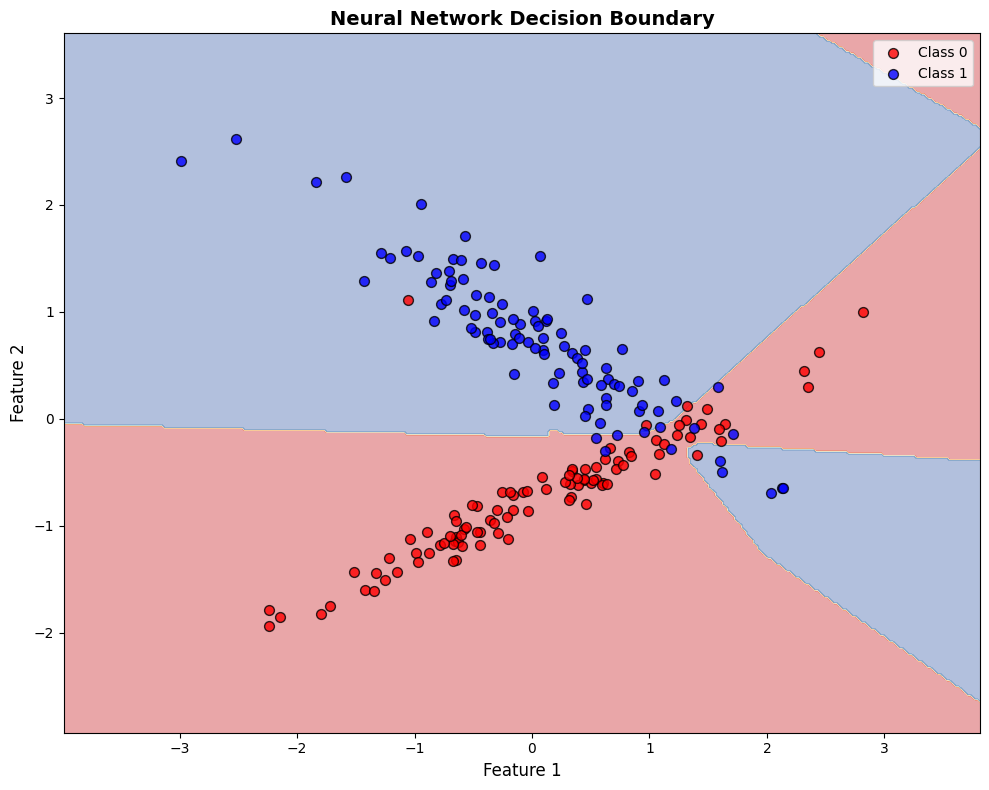

In [28]:
final_nn = NeuralNetwork(layers=[2, 8, 4, 1], learning_rate=0.01, activation='relu')
final_nn.fit(x_train_scaled, y_train, epochs=1000, batch_size=32, x_val=x_test_scaled, y_val=y_test)

# Final evaluation
final_pred = final_nn.predict(x_test_scaled)
final_proba = final_nn.predict_proba(x_test_scaled)
final_acc = final_nn.compute_accuracy(y_test, final_proba)

print(f"\nFinal Test Accuracy: {final_acc:.4f}")
plot_decision_boundary(final_nn, x_test_scaled, y_test)